<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb) | [Contents](Index.ipynb) | [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) for a discussion of this).
For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    # this is a static function, similar to C++
    # does not binded with a class instance
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

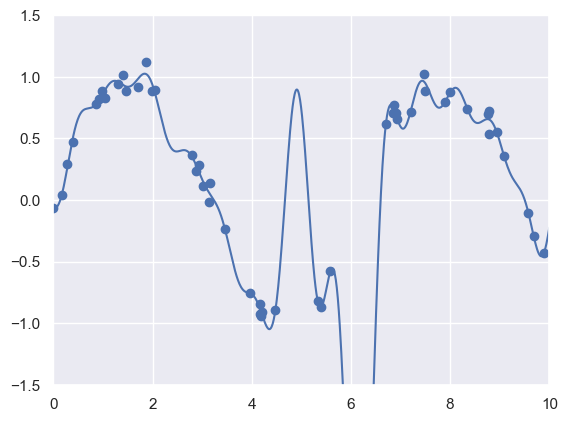

In [3]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

# 30-dimension is too big, will cause overfitting issue
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

# predict yfit based on xfit
xfit = np.linspace(0, 10, 1000)
# dot is the ground truth
plt.scatter(x, y)
# line is our model prediction
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

# it should be sin shape. Because overfitting, it is not sin shape
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data.
We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

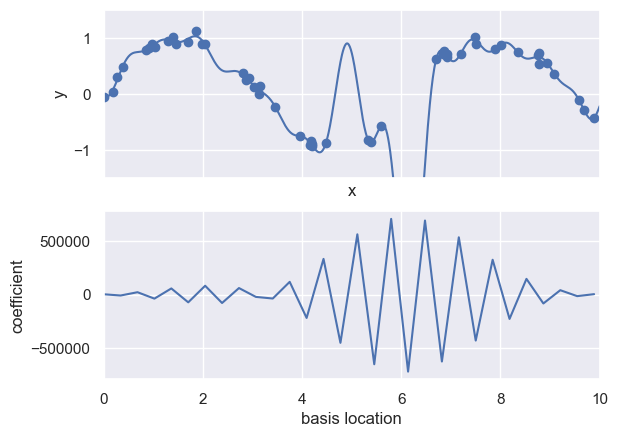

In [4]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
        
    # term
    # for each term we have coefficent and the center (mean value) of normal distribution
    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    # coefficient of each term
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
# bot amplitude of the basis function
# higher amplitude => overfitting
basis_plot(model)

The lower panel of this figure shows the amplitude of the basis function at each location.
This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out.
We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters.
Such a penalty is known as *regularization*, and comes in several forms.

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.
This type of penalized model is built into Scikit-Learn with the ``Ridge`` estimator:

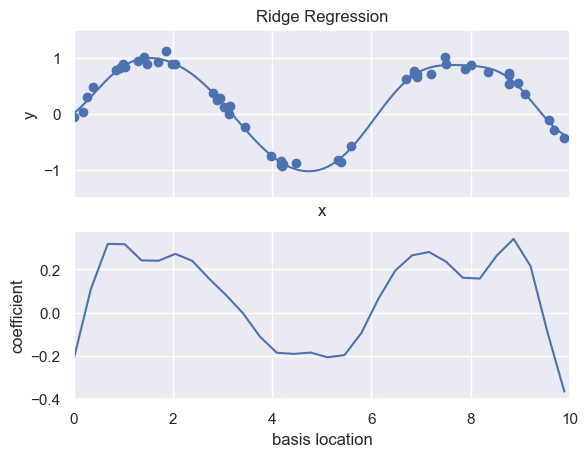

In [5]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
# after regularization, coefficient is much more reasonable
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor *sparse models* where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-03, tolerance: 2.065e-03
  model = cd_fast.enet_coordinate_descent(


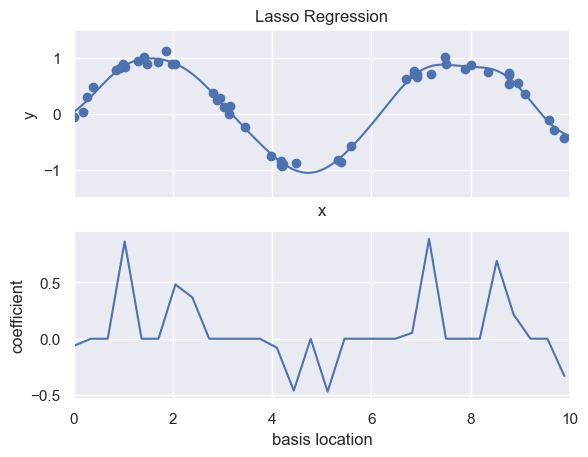

In [6]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions.
As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) for a discussion of this).

## Example: Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

In this section, we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.
Fortunately, the NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.
We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning.
As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

Let's start by loading the two datasets, indexing by date:

In [7]:
import pandas as pd
# these two files are large, and it may take a while to read...
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

/var/folders/_2/94xs_9c12nxdh70j9f0ldxs40000gn/T/ipykernel_27953/3700568954.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)


In [8]:
print(len(counts))
print(len(weather))
print(counts[:5])
print(weather[:5])

61296
1340
                     Fremont Bridge East Sidewalk  \
Date                                                
2019-01-01 00:00:00                           0.0   
2019-01-01 01:00:00                           2.0   
2019-01-01 02:00:00                           1.0   
2019-01-01 03:00:00                           1.0   
2019-01-01 04:00:00                           2.0   

                     Fremont Bridge West Sidewalk  
Date                                               
2019-01-01 00:00:00                           9.0  
2019-01-01 01:00:00                          22.0  
2019-01-01 02:00:00                          11.0  
2019-01-01 03:00:00                           2.0  
2019-01-01 04:00:00                           1.0  
                      STATION                                STATION_NAME  \
DATE                                                                        
2012-01-01  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-02  GHCND:USW0

Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [9]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
print(daily[:5])

             Total
Date              
2012-10-03  3521.0
2012-10-04  3475.0
2012-10-05  3148.0
2012-10-06  2006.0
2012-10-07  2142.0


We saw previously that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [10]:
# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun
Date                                                 
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0


Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [11]:
# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday
Date                                                          
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0


/var/folders/_2/94xs_9c12nxdh70j9f0ldxs40000gn/T/ipykernel_27953/2546541925.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily['holiday'].fillna(0, inplace=True)


We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

In [12]:
# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

print(daily[:5])

AttributeError: module 'pandas' has no attribute 'datetime'

We can also add the average temperature and total precipitation to the data.
In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [20]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')

daily[:5]

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,1.335,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,1.360,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,1.530,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,1.585,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,1.585,1.0


Finally, let's add a counter that increases from day 1, and measures how many years have passed.
This will let us measure any observed annual increase or decrease in daily crossings:

In [21]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [22]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,1.335,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,1.360,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,1.530,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,1.585,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,1.585,1.0,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data.
We will set ``fit_intercept = False``, because the daily flags essentially operate as their own day-specific intercepts:

In [23]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

In [14]:
# a little bit different than our previous example
# this plot is from pandas
daily[['Total', 'predicted']].plot(alpha=0.5);

KeyError: "['predicted'] not in index"

It is evident that we have missed some key features, especially during the summer time.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).
Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [25]:
# the estimated beta0 to betan
params = pd.Series(model.coef_, index=X.columns)
params

Mon                504.882756
Tue                610.233936
Wed                592.673642
Thu                482.358115
Fri                177.980345
Sat              -1103.301710
Sun              -1133.567246
holiday          -1187.401381
daylight_hrs       128.851511
PRCP           -168868.059965
dry day            547.698592
Temp (C)           651.627911
annual              26.942713
dtype: float64

This is not enough. Let's see the correlation matrix:

In [26]:
import matplotlib.pyplot as plt

daily[:5]
daily.corr(method='spearman')


,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Total,1.000000,0.147496,0.200247,0.186168,0.142324,0.054430,-0.360151,-0.370513,-0.111138,0.619643,-0.465832,0.620954,0.429007,0.235085,0.932395
Mon,0.147496,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,0.195584,0.000398,-0.025984,0.019339,0.017129,0.002658,0.143697
Tue,0.200247,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.018851,0.000651,0.006232,0.004455,-0.010122,0.003987,0.212646
Wed,0.186168,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.035347,-0.000582,0.005944,-0.011731,0.000779,-0.003987,0.197020
Thu,0.142324,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,0.030634,-0.000411,0.010861,-0.001635,-0.015572,-0.002658,0.140759
Fri,0.054430,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.035347,-0.000245,0.026654,0.000289,-0.037373,-0.001329,0.033788
Sat,-0.360151,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.068337,-0.000039,-0.017684,-0.005990,0.028030,0.000000,-0.356990
Sun,-0.370513,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.068337,0.000227,-0.006022,-0.004727,0.017129,0.001329,-0.370920
holiday,-0.111138,0.195584,-0.018851,-0.035347,0.030634,-0.035347,-0.068337,-0.068337,1.000000,-0.078683,-0.050033,-0.068660,0.059115,-0.027033,-0.130353
daylight_hrs,0.619643,0.000398,0.000651,-0.000582,-0.000411,-0.000245,-0.000039,0.000227,-0.078683,1.000000,-0.309827,0.791099,0.307485,0.251385,0.686755


Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model.
Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days).
These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

<!--NAVIGATION-->
< [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb) | [Contents](Index.ipynb) | [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
